# Imports

In [1]:
import os
import time
import random
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as layers

import gym
from gym import spaces
from PIL import Image
from collections import deque, namedtuple

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from environments import Snake
from methods import PGNetwork, ReplayMemory

SyntaxError: can't assign to function call (environments.py, line 49)

# Snake class

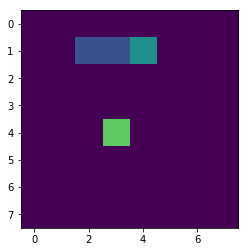

In [3]:
s = Snake()
img = s.reset()
s.plot_state()

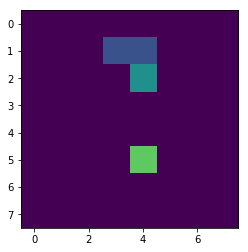

In [4]:
img, r, done = s.step(2)
s.plot_state()

# NN training

In [3]:
class SnakeAgent:
    
    def __init__(self, model_name="baseline_agent"):
        
        """Class for training and evaluating DQN agent on Atari games
        
        Parameters
        ----------
        game_id: str
            game identifier in gym environment, e.g. "Pong"
        num_actions: int
            number of actions the agent can take
        model_name: str
            name of the model
        """
        
        ############################ Game environment ############################
        
        self.train_env = Snake()
        self.num_actions = 4
            
        self.path = "snake_models" + "/" + model_name
        if not os.path.exists(self.path):
            os.makedirs(self.path)
        
        ############################# Agent & Target #############################
        
        tf.reset_default_graph()
        self.agent_net = PGNetwork(self.num_actions, scope="agent")
        self.target_net = PGNetwork(self.num_actions, scope="target")
        
        self.init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        
        all_vars = tf.trainable_variables()
        num_vars = len(all_vars) // 2
        self.agent_vars = all_vars[:num_vars]
        self.target_vars = all_vars[num_vars:]
        
    def set_parameters(self, 
                       replay_memory_size=50000,
                       replay_start_size=10000,
                       init_eps=1,
                       final_eps=0.1,
                       annealing_steps=100000,
                       discount_factor=0.99,
                       max_episode_length=2000):
        
        # create experience replay and fill it with random policy samples
        self.rep_buffer = ReplayMemory(replay_memory_size)
        frame_count = 0
        while (frame_count < replay_start_size):
            s = self.train_env.reset()
            for time_step in range(max_episode_length):
                a = np.random.randint(self.num_actions)
                s_, r, end = self.train_env.step(a)
                self.rep_buffer.push(s, a, np.sign(r), s_, end)
                s = s_
                frame_count += 1
                if end:
                    break
                        
        self.eps = init_eps
        self.final_eps = final_eps
        self.eps_drop = (init_eps - final_eps) / annealing_steps
        self.gamma = discount_factor
        self.max_ep_length = max_episode_length
        
    def train(self,
              gpu_id=0,
              batch_size=32,
              agent_update_freq=4,
              target_update_freq=5000,
              tau=1,
              max_num_episodes=100000,
              max_num_epochs=50000,
              performance_print_freq=100,
              save_freq=10000):
        
        target_ops = self.update_target_graph(tau)
        
        with tf.Session() as sess:
            sess.run(self.init)
            
            train_rewards = []
            Loss = []
            frame_count = 0
            episode_count = 0
            num_epochs = 0
            
            while num_epochs < max_num_epochs:
                
                train_ep_reward = 0
                
                # reset the environment / start new game
                s = self.train_env.reset()
                
                states = []
                actions = []
                values = []
                
                cum_sum = 0
                
                for time_step in range(self.max_ep_length):
                    
                    # choose action e-greedily
                    act_probs = self.agent_net.get_probs(sess, [s])
                    a = np.random.choice(self.num_actions, p=act_probs.ravel())
                    states.append(s)
                    actions.append(a)
                    values.append(cum_sum)  
                        
                    # make step in the environment    
                    s, r, end = self.train_env.step(a)
                    cum_sum += r * (self.gamma ** time_step)
                    
                    # update current state and statistics
                    frame_count += 1
                    train_ep_reward += r
                    
                    # make checkpoints of network weights and save learning curve
                    if frame_count % save_freq == 1:
                        num_epochs += 1
                        try:
                            self.saver.save(sess, self.path+"/model", global_step=num_epochs)
                            np.savez(self.path+"/learning_curve.npz", r=train_rewards)
                        except:
                            pass
                        
                    if end: break
                        
                for i in range(time_step + 1):
                    values[i] = (cum_sum - values[i]) / (self.gamma ** i)
                        
                # update network weights
                Loss.append(self.agent_net.update(sess, states, actions, values))
                         
                episode_count += 1
                train_rewards.append(train_ep_reward)
                
                # print performance once in a while
                if episode_count % performance_print_freq == 0:
                    avg_reward = np.mean(train_rewards[-performance_print_freq:])
                    avg_loss = np.mean(Loss[-performance_print_freq:])
                    print("Train info:", frame_count, avg_reward, avg_loss)  

    def update_target_graph(self, tau):
        op_holder = []
        for agnt, trgt in zip(self.agent_vars, self.target_vars):
            op = trgt.assign(agnt.value()*tau + (1 - tau)*trgt.value())
            op_holder.append(op)
        return op_holder

    def update_target_weights(self, sess, op_holder):
        for op in op_holder:
            sess.run(op)

In [4]:
aa = SnakeAgent(model_name="test")

In [5]:
aa.set_parameters(max_episode_length=1000, replay_memory_size=50000, replay_start_size=10000)

In [ ]:
aa.train(gpu_id=0)

Train info: 716 -0.87 -7.92802
Train info: 1553 -0.87 -9.56061
Train info: 2333 -0.88 -9.28464
Train info: 3153 -0.88 -9.44843
Train info: 3924 -0.86 -8.90056
Train info: 4872 -0.81 -10.0656
Train info: 5714 -0.9 -10.02
Train info: 6537 -0.87 -9.4829
Train info: 7340 -0.9 -9.90899
Train info: 8294 -0.93 -11.0706
Train info: 9070 -0.89 -8.94576
Train info: 9949 -0.88 -10.3047
Train info: 10657 -0.89 -7.31097
Train info: 11483 -0.89 -8.534
Train info: 12310 -0.87 -8.60118
Train info: 12997 -0.93 -7.93991
Train info: 13808 -0.92 -9.38263
Train info: 14568 -0.92 -8.34866
Train info: 15438 -0.95 -8.94581
Train info: 16213 -0.94 -7.92916
Train info: 16911 -0.92 -6.8394
Train info: 17608 -0.9 -6.75088
Train info: 18354 -0.93 -7.20269
Train info: 19090 -0.91 -6.64708
Train info: 19773 -0.91 -6.30946
Train info: 20460 -0.95 -6.64623
Train info: 21184 -0.9 -6.52309
Train info: 21816 -0.88 -4.91839
Train info: 22596 -0.88 -6.48838
Train info: 23357 -0.91 -6.73312
Train info: 24118 -0.91 -7.40631


Train info: 207587 -0.85 -6.49408
Train info: 208548 -0.84 -7.21177
Train info: 209517 -0.81 -7.98457
Train info: 210415 -0.81 -7.513
Train info: 211264 -0.82 -6.37512
Train info: 212125 -0.94 -6.81243
Train info: 212935 -0.9 -6.17414
Train info: 213846 -0.9 -7.1287
Train info: 214635 -0.8 -5.7416
Train info: 215527 -0.85 -7.31759
Train info: 216444 -0.85 -7.24217
Train info: 217504 -0.87 -9.18506
Train info: 218499 -0.92 -8.26034
Train info: 219531 -0.93 -8.95444
Train info: 220451 -0.82 -7.58978
Train info: 221401 -0.83 -8.16096
Train info: 222278 -0.85 -8.35477
Train info: 223052 -0.85 -6.60835
Train info: 223926 -0.93 -7.95407
Train info: 224929 -0.8 -8.52758
Train info: 225835 -0.77 -7.67651
Train info: 226867 -0.79 -8.41761
Train info: 227793 -0.88 -8.20828
Train info: 228771 -0.82 -8.67739
Train info: 229844 -0.86 -9.88698
Train info: 230789 -0.86 -8.90529
Train info: 231689 -0.87 -8.89247
Train info: 232572 -0.85 -8.12537
Train info: 233505 -0.86 -9.30961
Train info: 234571 -0.

Train info: 468274 -0.88 -10.3902
Train info: 469608 -0.9 -10.5771
Train info: 470785 -0.9 -8.64816
Train info: 471892 -0.93 -8.50729
Train info: 472942 -0.88 -8.03935
Train info: 473972 -0.82 -7.58598
Train info: 475163 -0.82 -8.60019
Train info: 476404 -0.87 -9.94333
Train info: 477566 -0.84 -9.06341
Train info: 478891 -0.89 -11.0912
Train info: 479989 -0.92 -10.1085
Train info: 481447 -0.88 -11.9833
Train info: 482536 -0.92 -8.97321
Train info: 483810 -0.91 -10.429
Train info: 484987 -0.88 -9.38562
Train info: 486494 -0.79 -11.4345
Train info: 487660 -0.89 -9.56046
Train info: 489255 -0.86 -11.5842
Train info: 490725 -0.87 -12.175
Train info: 492105 -0.86 -11.4498
Train info: 493453 -0.88 -11.2014
Train info: 494786 -0.85 -11.4291
Train info: 495989 -0.9 -11.0564
Train info: 497409 -0.83 -11.269
Train info: 498726 -0.86 -10.3734
Train info: 500127 -0.88 -10.9404
Train info: 501465 -0.81 -9.957
Train info: 502806 -0.79 -10.4803
Train info: 504109 -0.94 -11.4485
Train info: 505482 -0.

Train info: 784470 -0.77 -6.31149
Train info: 785829 -0.85 -6.98338
Train info: 787514 -0.78 -8.73551
Train info: 788949 -0.76 -6.83708
Train info: 790519 -0.76 -6.80227
Train info: 791996 -0.75 -7.00768
Train info: 793567 -0.8 -7.93534
Train info: 794878 -0.78 -6.18077
Train info: 796521 -0.81 -7.9308
Train info: 798082 -0.67 -5.97614
Train info: 799392 -0.7 -6.02884
Train info: 800819 -0.79 -7.05946
Train info: 802288 -0.74 -6.09835
Train info: 803575 -0.82 -6.92657
Train info: 804955 -0.77 -6.08528
Train info: 806276 -0.84 -6.00573
Train info: 807626 -0.79 -5.78721
Train info: 808958 -0.8 -6.20603
Train info: 810343 -0.72 -6.10542
Train info: 811567 -0.73 -5.63971
Train info: 812725 -0.78 -4.81466
Train info: 813960 -0.78 -5.99596
Train info: 814997 -0.77 -5.23376
Train info: 816186 -0.66 -4.91942
Train info: 817364 -0.78 -6.07902
Train info: 818615 -0.77 -6.12713
Train info: 819899 -0.81 -6.35368
Train info: 821303 -0.78 -7.49974
Train info: 822686 -0.81 -7.06276
Train info: 824010

# Visualization

In [3]:
tf.reset_default_graph()
agent_net = PGNetwork(4, scope="agent")
saver = tf.train.Saver()
env = Snake()

NameError: name 'PGNetwork' is not defined

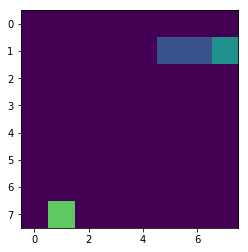

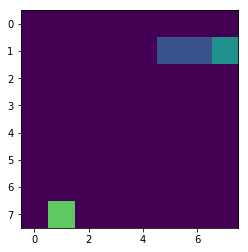

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "snake_models/test/model-55")
    s = env.reset()
    for i in range(20):
        probs = agent_net.get_probs(sess, [s])
        a = agent_net.get_p_argmax(sess, [s])[0]
        s, r, done = env.step(a)
        
        
        env.plot_state()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        
        if done: break

In [26]:
probs

array([[ 0.06805254,  0.69527936,  0.05574758,  0.18092045]], dtype=float32)